# Zillow: What is driving the errors in the Zestimates?

The Zillow Data Science Team wants to understand what is driving the errors in the zestimates?
- Data Scope:
    - 2017 properties
    - Single units / Single family homes

---

# Planning
- Agile Kanban: 
    - https://trello.com/b/aM5Pet9d/zillow-clustering-project
<br /> 
<br /> 
- The Zillow Data Science team would like to know:
    - **What is driving the errors (logerror) Zestimate in single unit properties?**

<br />

- Project Objectives:
    - See if bathroomcnt, bedroomcnt and calculatedfinishedsquarefeet are features which drive the error (logerror) Zestimate in single unit properties
    - Documenting process and analysis throughout the data science pipeline.
    - Constructing a clustered regression model that predicts the error (logerror) for Zestimates.
<br /> 
<br /> 

**Hypothesis:**
- $H$0 There is not a correlation between zestimate logerror with the following features: bathroomcnt, bedroomcnt and calculatedfinishedsquarefeet.
- $H$A There a correlation between between zestimate logerror with the following features: bathroomcnt, bedroomcnt and calculatedfinishedsquarefeet.

---

In [1]:
# imports for libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# imports from env file for credentials
from env import user, host, password

# sklearn imports
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# evaluating/modeling methods
import math
from math import sqrt
from math import pi
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


# imports from files
import acquire
import prepare
from prepare import Min_Max_Scaler

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# only have 2 decimal points for any calculations
pd.options.display.float_format = '{:,.2f}'.format 
#%precision %.2f

---

# Acquire
- Obtained the Zillow data from the SQL database utilizing the following query for 2017 single unit / single family home properties: 


<br /> 
select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
    from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;  
<br /> 


   - Refer to acquire.py, def get_zillow_data for more details 
   - Refer to final_prepare_explore.ipynb for further acquire details

---

# Prepare
- Within the final_prepare_explore.ipynb the following was done on the data for the final prepare and explore file: 
    - Drop all observations with one or more missing values:
        - df.dropna(inplace=True)
            - We dropped 1529 rows from the inital dataframe   
    <br />
    - We dropped any null values with 0
        - df = df.fillna(0)
    - Removed outlies: 
        - From the prepare.py file used function, 'remove_outliers()'
        - Removed outliers in bed, bath, zip, square feet, acres & tax rate
    <br />
    - Created a CSV file to model with:
        - df.to_csv('final_prepare_explore.csv')

In [2]:
# obtain the final prepare and explore csv file
df = pd.read_csv (r'final_prepare_explore.csv')
df.head()

,Unnamed: 0,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,cluster
0,0,14297519,0.03,3.50,4.00,"3,100.00","6,059.00","33,634,931.00","-117,869,207.00","4,506.00","53,571.00","1,286.00","96,978.00","1,998.00","485,713.00","1,023,282.00","537,569.00","11,013.72",cluster_1
1,1,17052889,0.06,1.00,2.00,"1,465.00","6,111.00","34,449,266.00","-119,281,531.00","12,647.00","13,091.00","2,061.00","97,099.00","1,967.00","88,000.00","464,000.00","376,000.00","5,672.48",cluster_0
2,2,14186244,0.01,2.00,3.00,"1,243.00","6,059.00","33,886,168.00","-117,823,170.00","8,432.00","21,412.00","1,286.00","97,078.00","1,962.00","85,289.00","564,778.00","479,489.00","6,488.30",cluster_0
3,3,12177905,-0.10,3.00,4.00,"2,376.00","6,037.00","34,245,180.00","-118,240,722.00","13,038.00","396,551.00","3,101.00","96,330.00","1,970.00","108,918.00","145,143.00","36,225.00","1,777.51",cluster_1
4,4,12095076,-0.00,3.00,4.00,"2,962.00","6,037.00","34,145,202.00","-118,179,824.00","63,000.00","47,019.00","3,101.00","96,293.00","1,950.00","276,684.00","773,303.00","496,619.00","9,516.26",cluster_1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52120 entries, 0 to 52119
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52120 non-null  int64  
 1   parcelid                      52120 non-null  int64  
 2   logerror                      52120 non-null  float64
 3   bathroomcnt                   52120 non-null  float64
 4   bedroomcnt                    52120 non-null  float64
 5   calculatedfinishedsquarefeet  52120 non-null  float64
 6   fips                          52120 non-null  float64
 7   latitude                      52120 non-null  float64
 8   longitude                     52120 non-null  float64
 9   lotsizesquarefeet             52120 non-null  float64
 10  regionidcity                  52120 non-null  float64
 11  regionidcounty                52120 non-null  float64
 12  regionidzip                   52120 non-null  float64
 13  y

In [4]:
# checking the nulls for the cleaned data: 
df.isnull().sum()

Unnamed: 0                      0
parcelid                        0
logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
cluster                         0
dtype: int64

In [5]:
df.shape

(52120, 19)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"52,120.00","26,223.43","15,137.50",0.00,"13,120.75","26,223.50","39,334.25","52,441.00"
parcelid,"52,120.00","12,955,044.31","2,274,805.97","10,711,855.00","11,506,688.75","12,577,655.00","14,127,267.50","162,960,814.00"
logerror,"52,120.00",0.02,0.17,-4.66,-0.02,0.01,0.04,3.39
bathroomcnt,"52,120.00",2.29,0.98,1.00,2.00,2.00,3.00,7.00
bedroomcnt,"52,120.00",3.30,0.92,1.00,3.00,3.00,4.00,7.00
calculatedfinishedsquarefeet,"52,120.00","1,906.98",937.70,152.00,"1,267.00","1,656.00","2,299.25","9,848.00"
fips,"52,120.00","6,049.11",21.00,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
latitude,"52,120.00","34,022,494.70","274,066.77","33,340,620.00","33,826,805.50","34,022,811.00","34,187,348.50","34,818,767.00"
longitude,"52,120.00","-118,193,519.34","356,168.65","-119,475,265.00","-118,399,722.50","-118,152,611.50","-117,929,080.50","-117,554,636.00"
lotsizesquarefeet,"52,120.00","11,068.65","86,361.00",0.00,"5,533.00","6,804.00","8,729.00","6,971,010.00"


**Takeaways**
- From a MVP perspective, the data is cleaned to explore

---

# Explore

<div class="alert alert-block alert-info"><b>Zestimate Feature Drivers:</b> We are looking to see what features can help us best predict the drivers for Zestimate errors </div>

<code style="background:yellow;color:black">Our target variable is: logerror, which notes the Zestimate errors.</code>

In [7]:
# Our target variable is: logerror, which notes the Zestimate errors
target_var = 'logerror'

In [8]:
prepare.split(df, target_var)

[       Unnamed: 0  parcelid  logerror  bathroomcnt  bedroomcnt  \
 4778         4805  12535098      0.00         2.00        3.00   
 9060         9123  10713904     -0.00         2.00        3.00   
 38162       38401  12385211     -0.01         2.00        3.00   
 26756       26923  12597233     -0.03         2.00        3.00   
 4400         4424  13989121      0.01         2.00        3.00   
 ...           ...       ...       ...          ...         ...   
 19209       19331  12268972     -0.03         1.00        2.00   
 42418       42686  11226968     -0.00         2.00        4.00   
 6669         6715  14239434      0.10         1.00        2.00   
 3272         3294  14503028     -0.01         2.00        3.00   
 44863       45143  12951350      0.20         3.00        2.00   
 
        calculatedfinishedsquarefeet     fips      latitude       longitude  \
 4778                       1,947.00 6,037.00 33,774,139.00 -118,144,313.00   
 9060                       1,310.00

In [9]:
partitions = prepare.split(df, target_var='logerror')

<code style="background:yellow;color:black">We will have 2 bins: Luxury and Opulence vs The Shrinking Middle Class.</code>

In [10]:
# Luxury & Opulence vs The Shrinking Middle Class
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, .2, 4])
partitions[0] = train

In [11]:
train.logerror_bins.value_counts()

(-5.0, 0.2]    27833
(0.2, 4.0]      1354
Name: logerror_bins, dtype: int64

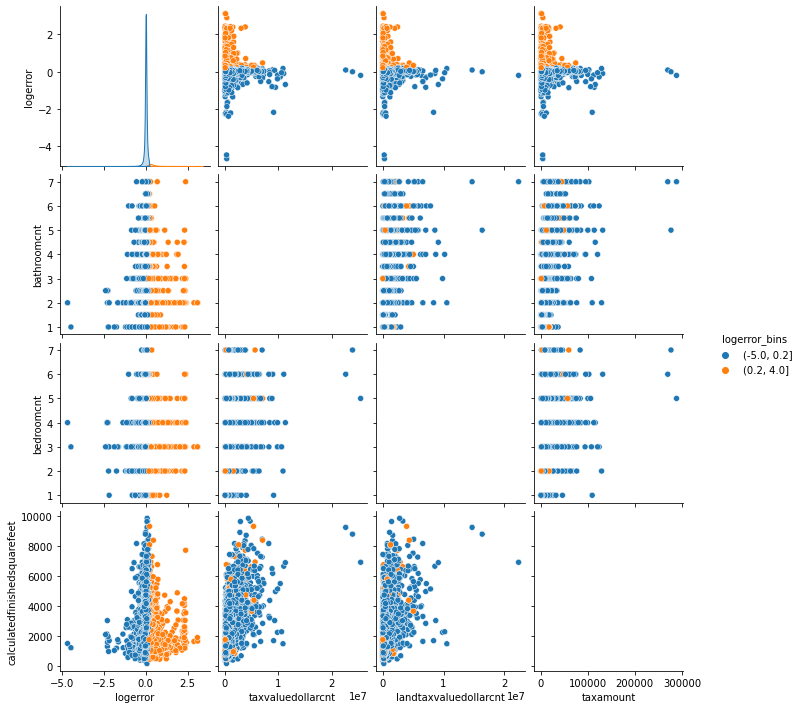

In [12]:
# we are wanting to focus on 'bathroomcnt', 'bedroomcnt' and 'calculatedfinishedsquarefeet' within our Lux and Middle class market clusters
sns.pairplot(data = train, hue = 'logerror_bins', 
             # 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin',  'taxrate', 'bath_bed_ratio'
             # 'acres', ,  'age'
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'])

<code style="background:yellow;color:black">Pairplot Takeaways:</code>

- There are 2 distinct clusters when looking at:
    - bathroomcnt
    - bedroomcnt
    - calculatedfinishedsquarefeet
    - Target: logerror

In [13]:
#the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'calculatedfinishedsquarefeet']

In [14]:
# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

In [15]:
# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

In [16]:
# fit the minmaxscaler to X_train
X_train = X[0]

In [17]:
# scaling the data
scaler = prepare.MinMaxScaler(copy=True).fit(X_train[scaled_vars])

In [18]:
# list of variables I will cluster on. 
cluster_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'] 
cluster_name = 'features_cluster'
k_range = range(2,20)

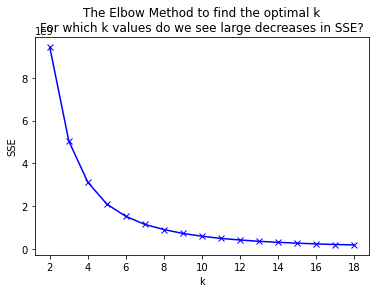

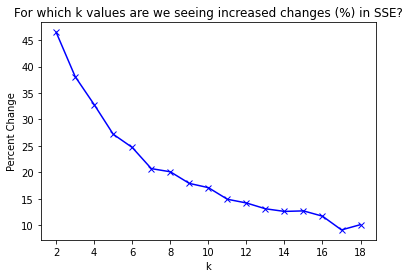

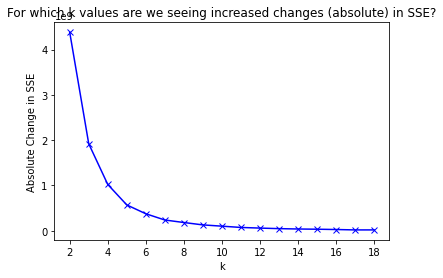

,k,sse,delta,pct_delta
0,2,"9,420,055,556.63","4,381,000,623.00",46.50
1,3,"5,039,054,934.04","1,920,824,564.00",38.10
2,4,"3,118,230,369.73","1,022,988,264.00",32.80
3,5,"2,095,242,105.81","570,945,876.00",27.20
4,6,"1,524,296,229.91","375,769,647.00",24.70
5,7,"1,148,526,583.32","238,107,538.00",20.70
6,8,"910,419,045.74","182,741,607.00",20.10
7,9,"727,677,438.98","129,968,906.00",17.90
8,10,"597,708,532.67","101,992,466.00",17.10
9,11,"495,716,066.83","73,728,010.00",14.90


In [19]:
prepare.find_k(X_train, cluster_vars, k_range)

<code style="background:yellow;color:black">We will try k=6, as we really need more clusters to make this meaningful.</code>


In [20]:
k = 6
# as reminders: 
cluster_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']
cluster_name = 'area_cluster'

In [21]:
# Create kmeans object & fit using training data.
prepare.create_clusters(X_train, k, cluster_vars)

KMeans(n_clusters=6, random_state=13)

In [22]:
X = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

In [23]:
df, X_scaled, scaler, kmeans, centroids = prepare.create_cluster(df, X, 3)

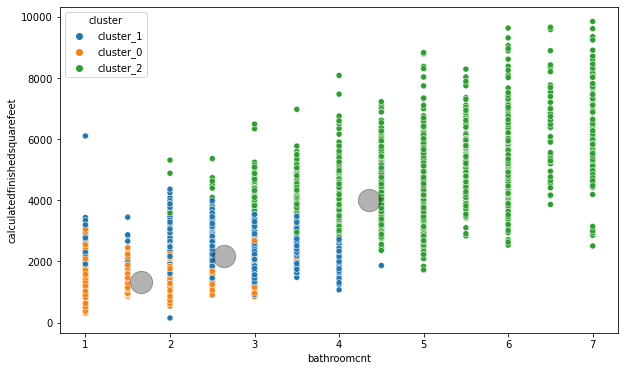

In [24]:
prepare.create_scatter_plot('bathroomcnt', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler)

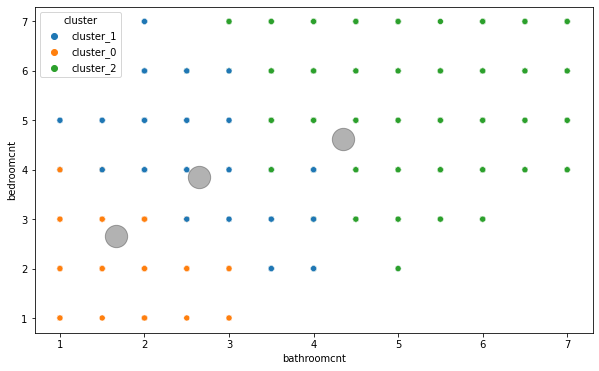

In [25]:
prepare.create_scatter_plot('bathroomcnt', 'bedroomcnt',df,kmeans, X_scaled, scaler)

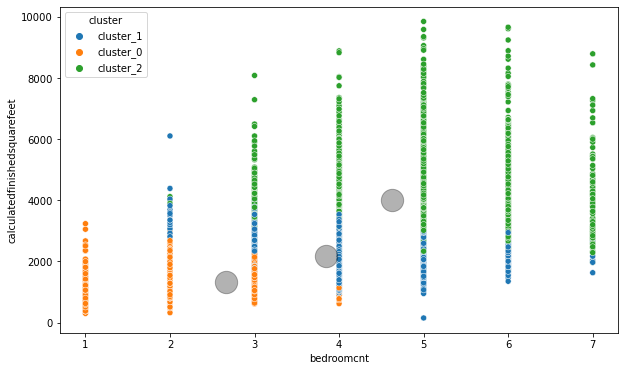

In [26]:
prepare.create_scatter_plot('bedroomcnt', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler)

<code style="background:yellow;color:black">Explore Scatter Plot Takeaways:</code>

- There are 3 distinct clusters when looking at:
    - bathroomcnt
    - bedroomcnt
    - calculatedfinishedsquarefeet
    - Target: logerror
    
<br />        

- The 3 distinct clusters look to be: 
    - <font color=orange>Orange</font> **The Middle Class Bucket** where we have about: 
        - 1-4 bedrooms
        - 1-3 bathrooms
        - 2,000 calcualted finished square feet
    - <font color=blue>Blue</font> **The Luxury Bucket** where we have about: 
        - 2-5 bedrooms
        - 1-4 bathrooms
        - 4,000 calcualted finished square feet
    - <font color=green>Green</font> **The Opulence Bucket** where we have about: 
        - 3-7 bedrooms
        - 3-7 bathrooms
        - 8,000 calcualted finished square feet

---

In [27]:
# checking the shape: 
df.shape

(52120, 19)

In [28]:
# split the data
train, validate, test = prepare.splits(df)

In [29]:
# checking the shape of the split datasets: 
train.shape, validate.shape, test.shape

((29187, 19), (12509, 19), (10424, 19))

In [30]:
# X and Y 
X_train = train[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train = train[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

X_validate = validate[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate = validate[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

X_test = test[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_test = test[['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

In [31]:
from sklearn.preprocessing import MinMaxScaler
from prepare import Min_Max_Scaler

In [32]:
#Min_Max_Scaler
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.Min_Max_Scaler(X_train, X_validate, X_test)

In [33]:
# Look at X_train
X_train_scaled.head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
16393,0.43,0.17,0.33,0.15
21412,0.43,0.33,0.33,0.20
2597,0.45,0.00,0.33,0.11
49861,0.42,0.17,0.33,0.13
5396,0.43,0.50,0.50,0.23


**Takeaways**
- Data is cleaned 
- Data is split into train, validate and test
- Data is scaled

**Statistical Tests**
- 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'
    - Correlation Test
    - T-Test

In [34]:
#Calculated Finished Square Feet x Logerror
null_hypothesis = "There is no correlation between calculatedfinishedsquarefeet and its logerror."
alternative_hypothesis = "There is a correlation  between calculatedfinishedsquarefeet and its logerror."
confidence_level = .95
alpha = 1 - confidence_level

corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.logerror)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

We reject the null hypothesis.
We can move forward with the alternative hypothesis: There is a correlation  between calculatedfinishedsquarefeet and its logerror.


In [35]:
#t-test on entire train set for square feet
t, p = stats.ttest_ind(train.logerror,train.calculatedfinishedsquarefeet, equal_var=False)

In [36]:
print("t= {0:.2f}".format(t))
print("p= {0:.2f}".format(p))
print("alpha= {0:.2f}".format(alpha))

t= -348.11
p= 0.00
alpha= 0.05


In [37]:
p <alpha

True

In [38]:
# Bathroomcnt x Logerror
null_hypothesis = "There is no correlation between bathroomcnt and its logerror."
alternative_hypothesis = "There is a correlation between bathroomcnt and its logerror."
confidence_level = .95
alpha = 1 - confidence_level

corr, p = stats.pearsonr(train.bathroomcnt, train.logerror)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

We reject the null hypothesis.
We can move forward with the alternative hypothesis: There is a correlation between bathroomcnt and its logerror.


In [39]:
#t-test on entire train set for county code
t, p = stats.ttest_ind(train.logerror,train.bathroomcnt, equal_var=False)

In [40]:
print("t= {0:.2f}".format(t))
print("p= {0:.2f}".format(p))
print("alpha= {0:.2f}".format(alpha))

t= -390.83
p= 0.00
alpha= 0.05


In [41]:
p <alpha

True

In [42]:
# Bedroomcnt x Logerror
null_hypothesis = "There is no correlation between bedroomcnt and its logerror."
alternative_hypothesis = "There is a correlation between bedroomcnt and its logerror."
confidence_level = .95
alpha = 1 - confidence_level

corr, p = stats.pearsonr(train.bedroomcnt, train.logerror)

if p < alpha:
    print("We reject the null hypothesis.")
    print("We can move forward with the alternative hypothesis:", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

We reject the null hypothesis.
We can move forward with the alternative hypothesis: There is a correlation between bedroomcnt and its logerror.


In [43]:
#t-test on entire train set for county code
t, p = stats.ttest_ind(train.logerror,train.bedroomcnt, equal_var=False)

In [44]:
print("t= {0:.2f}".format(t))
print("p= {0:.2f}".format(p))
print("alpha= {0:.2f}".format(alpha))

t= -601.94
p= 0.00
alpha= 0.05


In [45]:
p <alpha

True

<code style="background:yellow;color:black">Explore Statistical Test Takeaways:</code>

- We reject the null hypothesis for the following: :
    - Calculated Finished Square Feet x Logerror
    - Bathroomcnt x Logerror
    - Bedroomcnt x Logerror

# Modeling

In [46]:
# X_train_scaled dataframe
X_train_scaled.head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
16393,0.43,0.17,0.33,0.15
21412,0.43,0.33,0.33,0.20
2597,0.45,0.00,0.33,0.11
49861,0.42,0.17,0.33,0.13
5396,0.43,0.50,0.50,0.23


In [47]:
# Baseline
# Need to have y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [48]:
# Predict logerror_mean

#predicted mean will be the mean of logerror column
logerror_pred_mean = y_train['logerror'].mean()

#new column created
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

In [49]:
y_train.head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror_pred_mean
16393,-0.00,2.00,3.00,"1,650.00",0.02
21412,-0.00,3.00,3.00,"2,115.00",0.02
2597,0.12,1.00,3.00,"1,196.00",0.02
49861,-0.03,2.00,3.00,"1,419.00",0.02
5396,0.02,4.00,4.00,"2,399.00",0.02


In [50]:
# RMSE of logerror_pred_mean

#root mean squared error of the predicted mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.18


In [51]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

metric_df
# baseline

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,0.17,0.18,0.00


In [52]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict mean of logerror
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#Compute logerror_pred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

In [53]:
import model

In [92]:
#Modeling Functions
def residuals(actual, predicted):
    return actual - predicted

def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))


def evaluation_metrics_mean(actual):
    predicted = actual.mean()
    return {'sse': round(sse(actual, predicted)), 
            'mse': round(mse(actual, predicted)), 
            'rmse': round(rmse(actual, predicted))}

def evaluation_metrics_median(actual):
    predicted = actual.median()
    return {'sse': round(sse(actual, predicted)), 
            'mse': round(mse(actual, predicted)), 
            'rmse': round(rmse(actual, predicted))}

In [95]:
#Use the mean to evaluate baseline model
print(model.evaluation_metrics_mean(y_train.logerror))
print(evaluation_metrics_mean(y_train.logerror))

{'sse': 853.7546478950901, 'mse': 0.02925119566571042, 'rmse': 0.1710298092898148}
{'sse': 854, 'mse': 0, 'rmse': 0}


In [55]:
# before drop of target variable 
train.columns

Index(['Unnamed: 0', 'parcelid', 'logerror', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcity', 'regionidcounty', 'regionidzip',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'cluster'],
      dtype='object')

In [56]:
# dropping target variable 'logerror' from the train data set
train = train.drop(columns=['logerror'])

In [57]:
# the target variable 'logerror' is no longer within the train columns
train.columns

Index(['Unnamed: 0', 'parcelid', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcity', 'regionidcounty', 'regionidzip',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'cluster'],
      dtype='object')

In [58]:
# need to convert floats to into int
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29187 entries, 16393 to 24876
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    29187 non-null  int64  
 1   parcelid                      29187 non-null  int64  
 2   bathroomcnt                   29187 non-null  float64
 3   bedroomcnt                    29187 non-null  float64
 4   calculatedfinishedsquarefeet  29187 non-null  float64
 5   fips                          29187 non-null  float64
 6   latitude                      29187 non-null  float64
 7   longitude                     29187 non-null  float64
 8   lotsizesquarefeet             29187 non-null  float64
 9   regionidcity                  29187 non-null  float64
 10  regionidcounty                29187 non-null  float64
 11  regionidzip                   29187 non-null  float64
 12  yearbuilt                     29187 non-null  float64
 1

**Tweedie Regressor Model**

In [100]:
# create the model object
glm = TweedieRegressor(power=-1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# convert to a dataframe from a series 
glm.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm) ** (1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.17102980928981482 
Validation/Out-of-Sample:  0.17649318221099203


**OLS Model**

In [61]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# convert to a dataframe from a series 
lm.fit(X_train_scaled, y_train.logerror)


# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)


# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  3.8429125718062074e-16 
Validation/Out-of-Sample:  3.860532209485867e-16


**Polynomial Regression**

In [101]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# convert to a dataframe from a series 
lm2.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.0 
Validation/Out-of-Sample:  1.4903708940477828e-31


**Laso Lars**

In [103]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  3.8429125718062074e-16 
Validation/Out-of-Sample:  3.860532209485867e-16


# Takeaways: 


# Model Findings

In [104]:
#out of sample evaluation
y_test = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  3.8565004430528083e-16
